In [49]:
import pandas as pd
import numpy as np
import spacy
import re

from gensim.models import Phrases, LdaModel, CoherenceModel, Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim

from ast import literal_eval

In [50]:
data = pd.read_csv("../data/interim/trigrams3.csv")
data['TRIGRAMS'] = data['TRIGRAMS'].apply(literal_eval)
data.head()

,Unnamed: 0,NUM,FACILITY,DATE,FINE,NARRATIVE,TRIGRAMS
0,0,20008964,FREMONT HEALTHCARE CENTER,2012-02-01,$750,F323 483.25(h) FREE OF ACCIDENT HAZARDS/SUPERV...,"[hazard_supervision_device, device_prevent_acc..."
1,1,20009068,WILLOW TREE NURSING CENTER,2012-03-02,$750,Title 22 72520 (a) If a patient of a skilled n...,"[skilled_nursing_facility, hospital_define_sec..."
2,2,20009069,KINDRED NURSING AND REHABILITATION - YGNACIO V...,2012-03-02,$750,483.12(b) (3) Permitting Resident to Return to...,"[bed_hold_period, facility_immediately_availab..."
3,3,20009078,"BAY VIEW REHABILITATION HOSPITAL, LLC",2012-03-05,"$37,500",483.25 PROVIDE CARE/SERVICES FOR HIGHEST WELL ...,"[service_high_beingeach, facility_provide_nece..."
4,4,20009082,LONE TREE CONVALESCENT HOSPITAL,2012-03-06,$600,T22 DIV5 CH3 ART3-72311(a)(1)(A) Nursing Servi...,"[nursing_service_shall, include_limit_followin..."


In [51]:
def remove_numbers(corpus):
    regexp = re.compile(r'^[0-9]*$')
    return [[word for word in line if not regexp.search(word)] for line in corpus]

In [52]:
# Fill a dictionary with all of the words and phrases in the corpus, except for pure numbers like "2016", which
# do not contain much valuable info about what topic a narrative belongs to. Filter out words that occur too often
# or not often enough. Then convert the dictionary to vectors.

corpus = data['TRIGRAMS'].tolist()
corpus = remove_numbers(corpus)
dct = Dictionary(corpus)
dct.filter_extremes(no_below=2, no_above=0.15)
corpus_nums = [dct.doc2bow(text) for text in corpus]

In [53]:
%%time

# Train an LDA model, somewhat more carefully, using the hyperparameters that were close to optimal in the previous
# notebook. Although a 3-topic model had slightly more coherence, that is less interesting than an 8-topic model,
# and the coherence statistics were very similar.

retrainFullModel = False

if retrainFullModel:
    full_lda_model = LdaModel(corpus_nums, num_topics=8, id2word=dct, passes=60, iterations=1200, 
                         alpha=0.9, eta=0.9, random_state=42)
    full_lda_model.save("../models/full_lda")
    dct.save_as_text("../models/full_lda_dct")

full_lda_model = LdaModel.load("../models/full_lda")
dct = Dictionary.load_from_text("../models/full_lda_dct")

Wall time: 200 ms


In [54]:
# Test that model was successful
for topic in range(2):
    print([(a, round(b*100, 2)) for (a, b) in full_lda_model.show_topic(topic, topn=5)])
    print("\n")

[('oxygen', 0.59), ('tube', 0.55), ('gach', 0.51), ('urinary', 0.32), ('respiratory', 0.32)]


[('dcs', 0.53), ('sexual', 0.31), ('police', 0.23), ('disability', 0.22), ('october', 0.2)]




In [55]:
def get_best_topic(document, model):
    best_topic = None
    best_prob = 0
    candidates = model.get_document_topics(document)
    for (topic, prob) in candidates:
        if prob > best_prob:
            best_topic = topic
            best_prob = prob
    return best_topic

In [56]:
# Assign each dcoument to the topic that it is most strongly associated with

data.loc[:, 'TOPIC'] = [get_best_topic(corpus_nums[row], full_lda_model) 
                        for row in range(len(data))]

In [57]:
data.head()

,Unnamed: 0,NUM,FACILITY,DATE,FINE,NARRATIVE,TRIGRAMS,TOPIC
0,0,20008964,FREMONT HEALTHCARE CENTER,2012-02-01,$750,F323 483.25(h) FREE OF ACCIDENT HAZARDS/SUPERV...,"[hazard_supervision_device, device_prevent_acc...",3
1,1,20009068,WILLOW TREE NURSING CENTER,2012-03-02,$750,Title 22 72520 (a) If a patient of a skilled n...,"[skilled_nursing_facility, hospital_define_sec...",0
2,2,20009069,KINDRED NURSING AND REHABILITATION - YGNACIO V...,2012-03-02,$750,483.12(b) (3) Permitting Resident to Return to...,"[bed_hold_period, facility_immediately_availab...",0
3,3,20009078,"BAY VIEW REHABILITATION HOSPITAL, LLC",2012-03-05,"$37,500",483.25 PROVIDE CARE/SERVICES FOR HIGHEST WELL ...,"[service_high_beingeach, facility_provide_nece...",0
4,4,20009082,LONE TREE CONVALESCENT HOSPITAL,2012-03-06,$600,T22 DIV5 CH3 ART3-72311(a)(1)(A) Nursing Servi...,"[nursing_service_shall, include_limit_followin...",4


In [58]:
# Group the documents based on topic and calculate the average fine for each topic

means = data.groupby(['TOPIC']).mean()
means.index = ["CPR", "Abuse", "Theft", "Burns", "Sores", "Diet", "Rashes", "Diabetes"]
pd.options.display.float_format = '${:,.0f}'.format
means = means.sort_values('FINE', ascending=False)
means = means.drop(['Unnamed: 0', 'NUM'], axis=1)
means

,FINE
CPR,"$13,252"
Sores,"$9,448"
Burns,"$6,706"
Diabetes,"$5,468"
Diet,"$3,736"
Abuse,"$3,619"
Rashes,"$2,663"
Theft,"$1,732"


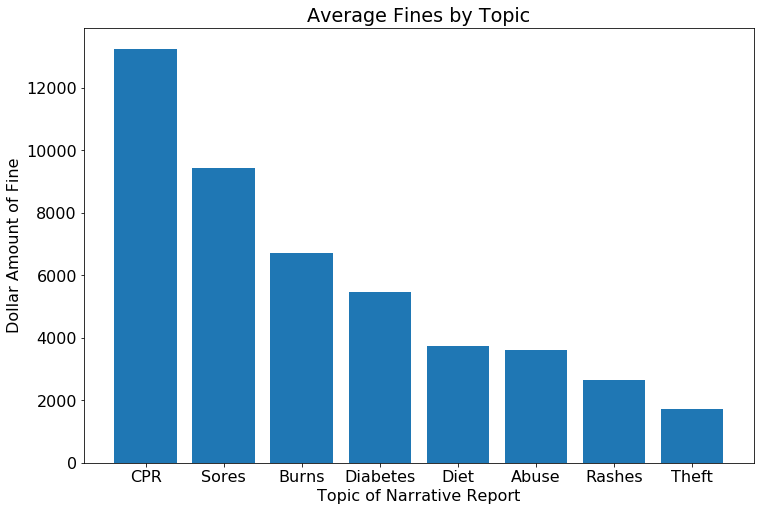

In [59]:
# Graph the average fine per topic

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.bar(means.index, means['FINE'])
plt.ylabel('Dollar Amount of Fine')
plt.xlabel('Topic of Narrative Report')
plt.title('Average Fines by Topic')
plt.rcParams.update({'font.size': 16})
plt.show()

In [60]:
# List the most common words in each topic

for topic in range(8):
    print([(a, round(b*100, 2)) for (a, b) in full_lda_model.show_topic(topic, topn=15)])
    print("\n")

[('oxygen', 0.59), ('tube', 0.55), ('gach', 0.51), ('urinary', 0.32), ('respiratory', 0.32), ('urine', 0.31), ('catheter', 0.31), ('cpr', 0.28), ('breathing', 0.27), ('paramedic', 0.23), ('blood_pressure', 0.23), ('rate', 0.22), ('change_condition', 0.22), ('lung', 0.22), ('bowel', 0.21)]


[('dcs', 0.53), ('sexual', 0.31), ('police', 0.23), ('disability', 0.22), ('october', 0.2), ('yell', 0.19), ('february', 0.19), ('july', 0.19), ('ln', 0.18), ('qidp', 0.18), ('january', 0.18), ('right_free', 0.18), ('september', 0.17), ('aggressive', 0.16), ('wander', 0.16)]


[('account', 1.79), ('trust', 1.2), ('ad', 0.69), ('trust_account', 0.67), ('fund', 0.67), ('money', 0.63), ('o', 0.62), ('$', 0.61), ('snf', 0.51), ('transfer_discharge', 0.49), ('ssd', 0.44), ('o_ad', 0.41), ('restraint', 0.37), ('bank', 0.37), ('monie', 0.35)]


[('drug', 0.73), ('temperature', 0.63), ('water', 0.57), ('mar', 0.41), ('degree', 0.4), ('dose', 0.36), ('hot', 0.36), ('tablet', 0.35), ('july', 0.31), ('narcotic